![](../JFM-notebooks-logo.jpg)

In [3]:
import numpy as np
import h5py
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import cmocean

# Aesthetics
sns.set_theme()
sns.set_style('ticks')
sns.set_context('paper')
plt.rc('mathtext', fontset='stix')
plt.rc('font', family='serif')

### Define consistent colours and line styles for variations in $Re$, $Gr$, and $Pr$

In [4]:
camp = sns.color_palette('flare', as_cmap=True)
cspeed = cmocean.tools.crop_by_percent(cmocean.cm.tempo, 30, which='both', N=None)

def Re_col(lR):
    return camp((lR - 2.5)/1.5)

def Gr_col(lG):
    return cspeed((lG - 6)/2)

def Pr_stl(Pr):
    if Pr==1:
        stl = '-'
    elif Pr==4:
        stl = '--'
    elif Pr==10:
        stl = ':'
    else:
        stl = '-.'
    return stl

### Average profiles using (anti-)symmetry across the midplane

In [5]:
def sym_prof(v):
    n = v.size
    return 0.5*(v[:n//2] + v[-1:-n//2-1:-1])
def asym_prof(v):
    n = v.size
    return 0.5*(v[:n//2] - v[-1:-n//2-1:-1])

### Define first derivative operator to act on mean profiles

In [6]:
def ddx(A, x, BClo=0.0, BCup=0.0):
    """
    Computes the wall-normal derivative of the space(-time) data `A`
    which sits on the grid `x`. Upper and lower boundary values, at
    x=1 and x=0 respectively, can be set by the optional arguments
    `BCup` and `BClo`.
    """
    dA = np.zeros(A.shape)
    A = np.array(A)
    x = np.array(x)
    if dA.ndim==2:
        dA[0,:] = (A[1,:] - BClo)/x[1]
        dA[1:-1,:] = (A[2:,:] - A[:-2,:])/(x[2:] - x[:-2]).reshape(x.size-2,1)
        dA[-1,:] = (BCup - A[-2,:])/(1.0 - x[-2])
    elif dA.ndim==1:
        dA[0] = (A[1] - BClo)/x[1]
        dA[1:-1] = (A[2:] - A[:-2])/(x[2:] - x[:-2])
        dA[-1] = (BCup - A[-2])/(1.0 - x[-2])
    return dA

### Use linear interpolation to compute a mean velocity profile on the refined grid

In [7]:
def interp_profile(v, x, xr):
    vex = np.zeros(v.size+2)
    xx = np.zeros(vex.size)
    xx[1:-1] = x
    xx[-1] = 1.0
    vex[0] = 0.0
    vex[1:-1] = v
    vex[-1] = 0.0
    vr = np.interp(xr, xx, vex)
    return vr

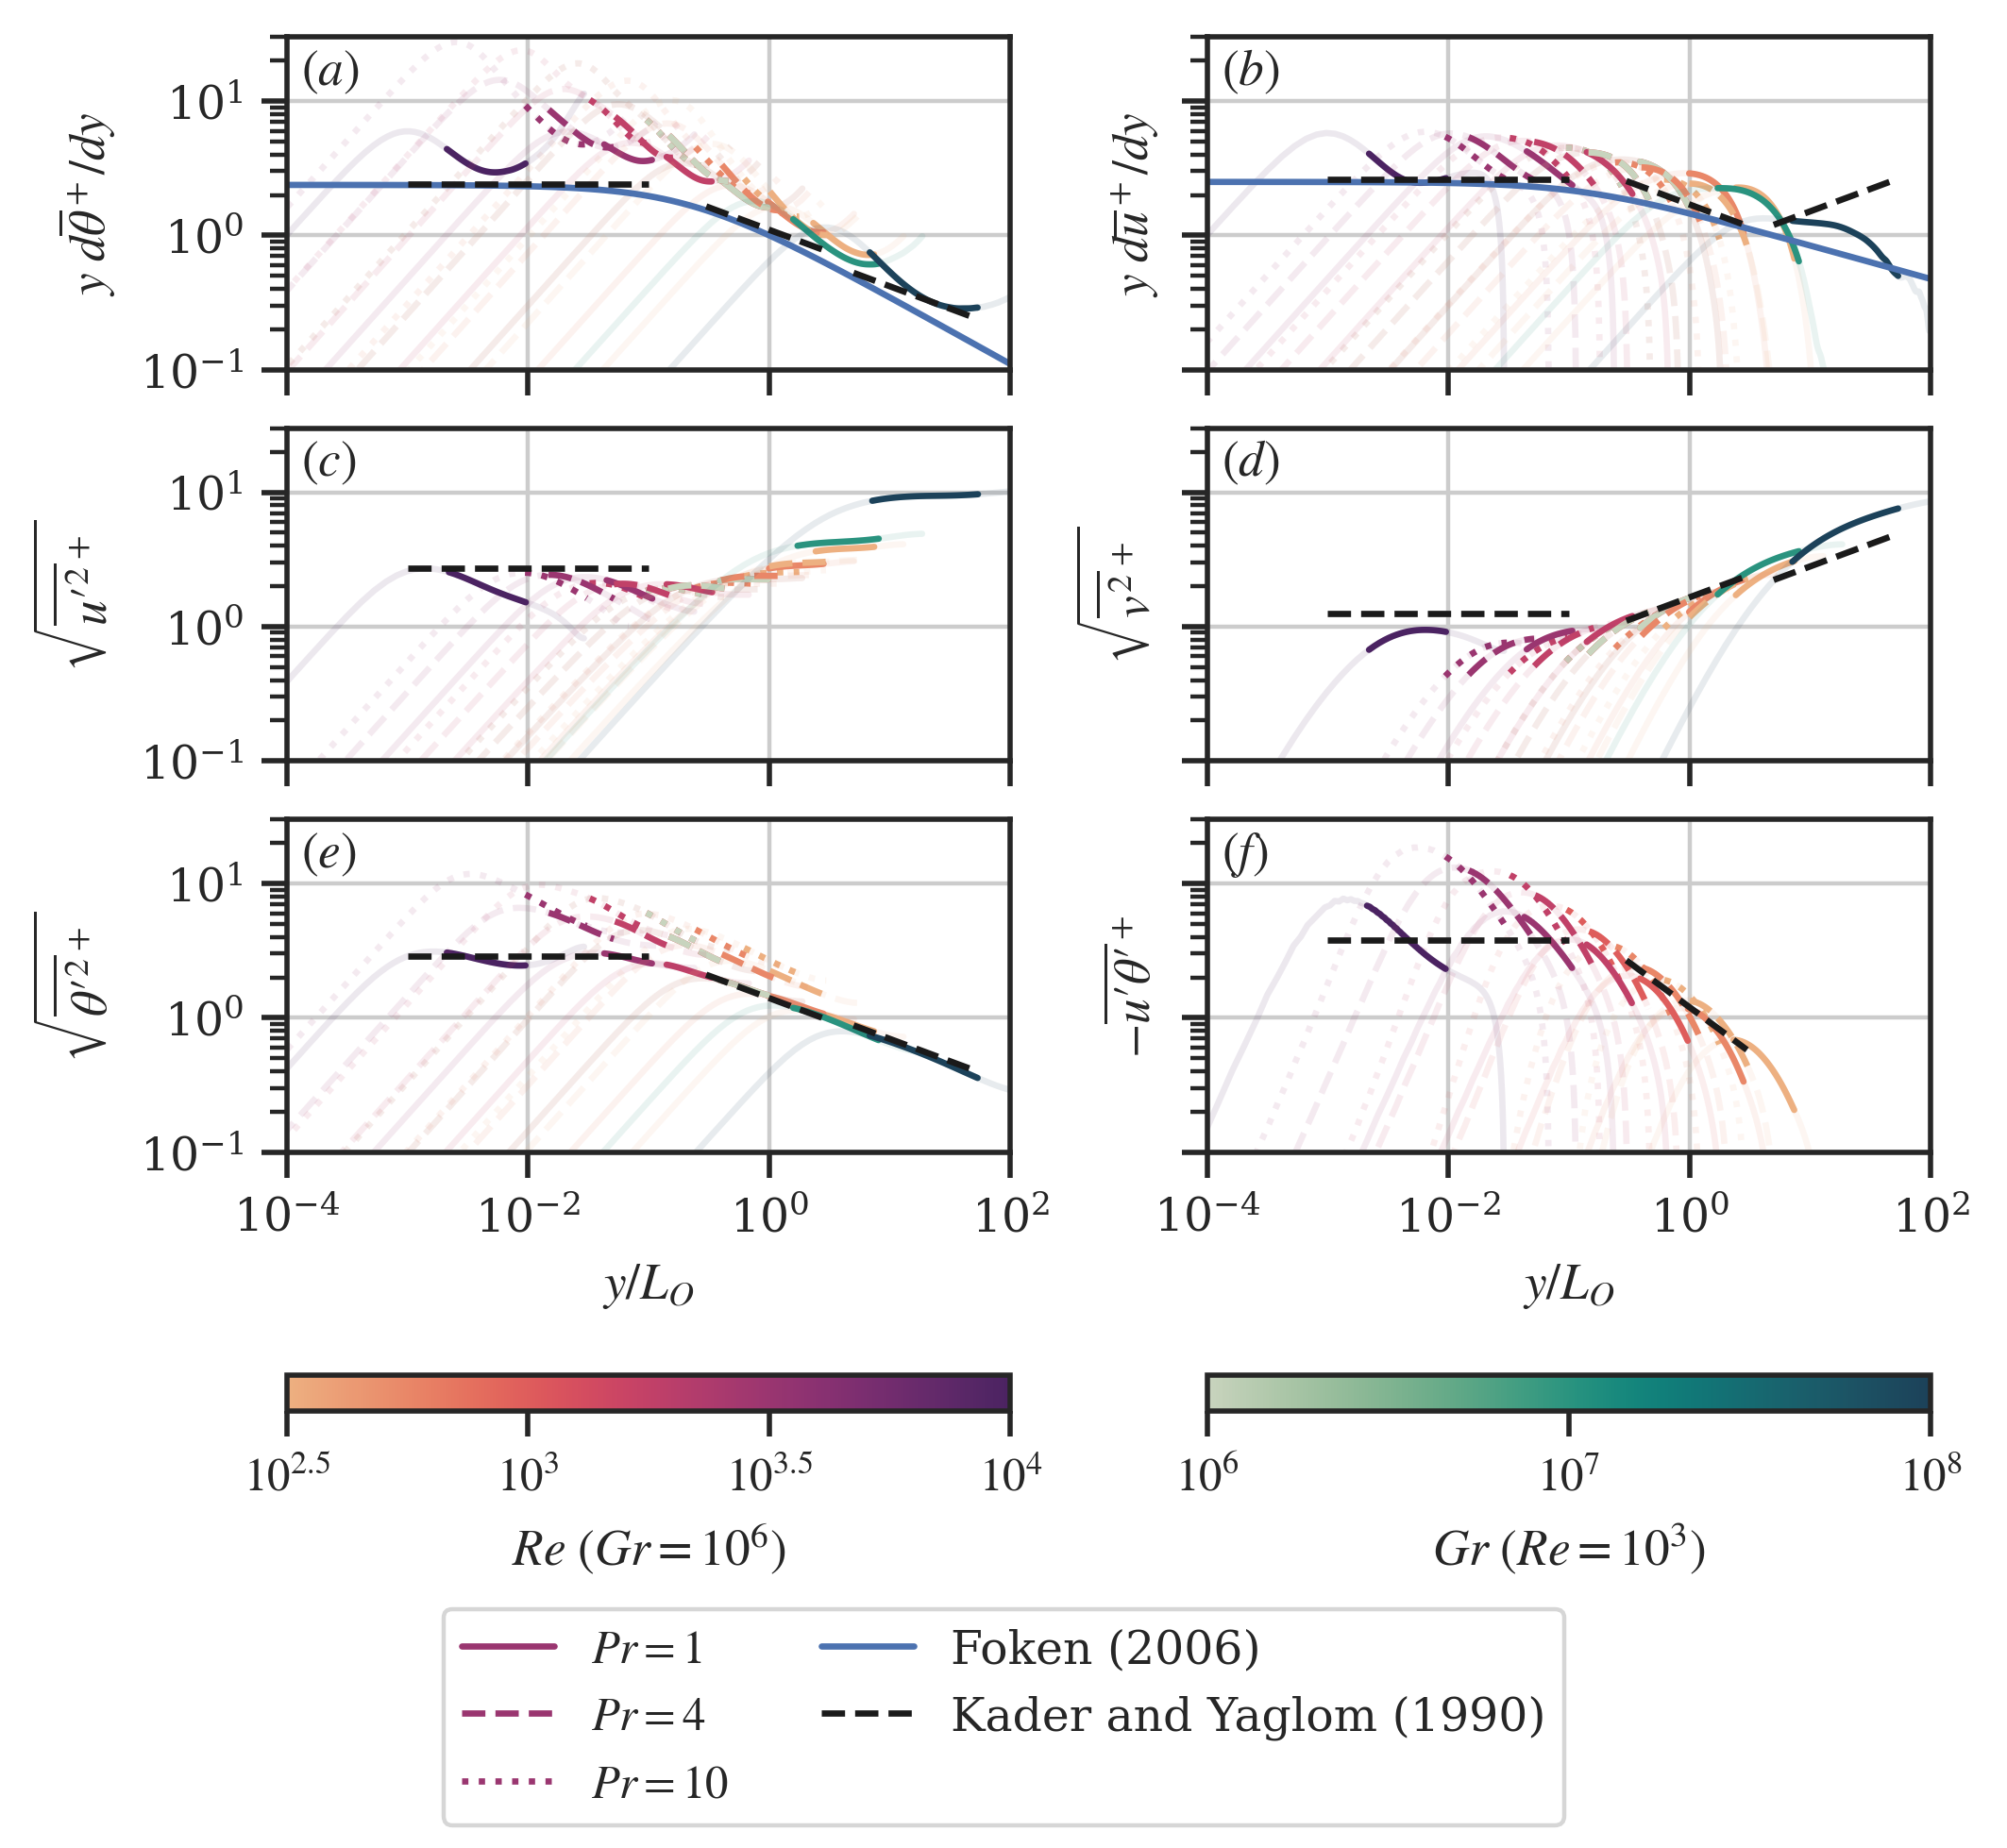

In [8]:
fig, axs = plt.subplots(3,2, figsize=(5.2,4.8), layout='constrained', dpi=200, sharex=True, sharey=True)

xh = []
Ph = []

with h5py.File('../data/profile_record.h5','r') as fp:

    for grp in fp.__iter__():
        # Read mean profile
        x = fp[grp+'/xm'][:]
        xs = x[:x.size//2]
        xr = fp[grp+'/xmr'][:]
        xsr = xr[:xr.size//2]

        vzbar = fp[grp+'/vzbar'][:]
        ur = interp_profile(vzbar, x, xr)
        dU = ddx(vzbar, x)
        vzbar = sym_prof(vzbar)
        ur = sym_prof(ur)
        dU = asym_prof(dU)
        uv = asym_prof(fp[grp+'/vxvz'][:])

        urms = sym_prof(np.sqrt(fp[grp+'/vzrms'][:]**2 - fp[grp+'/vzbar'][:]**2))
        vrms = sym_prof(fp[grp+'/vxrms'][:])

        Tbar = -fp[grp+'/Sbar'][:]
        dT = ddx(Tbar, xr, BClo=0.5, BCup=-0.5)
        Tbar = asym_prof(Tbar)
        dT = sym_prof(dT)
        vT = sym_prof(-fp[grp+'/vxS'][:])

        Trms = sym_prof(np.sqrt(fp[grp+'/Srms'][:]**2 - fp[grp+'/Sbar'][:]**2))
        uT = asym_prof(-fp[grp+'/vzS'][:]) - ur*Tbar

        # Read control parameters (logarithms)
        lGr = int(grp[2])
        lRe = float(grp[-4:])
        lRi = lGr - 2*lRe

        # Find region where M-O assumptions hold
        fluxfrac = 0.8
        xmin = xs[np.nonzero(uv < fluxfrac*uv.min())[0][0]]
        xmax = xs[np.nonzero(uv < fluxfrac*uv.min())[0][-1]]
        xmin = np.maximum(xmin, xsr[np.nonzero(vT > fluxfrac*vT.max())[0][0]])
        xmax = np.minimum(xmax, xsr[np.nonzero(vT > fluxfrac*vT.max())[0][-1]])

        # Exclude cases with no pressure gradient
        if lRe > 0:
            # Compute free-fall and bulk velocity scales
            Uf = 10**np.min([lGr/2 - lRe, 0])
            Ub = 10**np.min([lRe - lGr/2, 0])
    
            Gr = 10**lGr
            Re = 10**lRe
            Pr = int(grp[6:-7])

            # Compute dimensionless friction velocity/shear Reynolds number
            Wtau = (vzbar[0]/x[0] / np.max([Gr**0.5,Re]) )**0.5
            Retauz2 = Wtau*np.max([Gr**0.5,Re])

            # Compute Nusselt number from boundary gradient
            Nu = (0.5 - Tbar[0])/xr[0]
            Thet = Nu/Retauz2/Pr
            kappa = Uf*Gr**-0.5/Pr

            # Compute Obukhov length scale
            LO = Pr/Gr*Retauz2**3/Nu

            # Gr=10^6 cases
            if 'Gr6' in grp:
                axs[0,0].loglog(xsr/LO, -xsr/Thet*dT, color=Re_col(lRe), linestyle=Pr_stl(Pr), alpha=0.1)
                xh.append((xsr/LO)[(xsr >= xmin)*(xsr <= xmax)])
                Ph.append((-xsr/Thet*dT)[(xsr >= xmin)*(xsr <= xmax)])
                axs[0,0].loglog((xsr/LO)[(xsr >= xmin)*(xsr <= xmax)], (-xsr/Thet*dT)[(xsr >= xmin)*(xsr <= xmax)], color=Re_col(lRe), linestyle=Pr_stl(Pr))
                axs[0,1].loglog(xs/LO, xs/Wtau*dU, color=Re_col(lRe), linestyle=Pr_stl(Pr), alpha=0.1)
                axs[0,1].loglog((xs/LO)[(xs >= xmin)*(xs <= xmax)], (xs/Wtau*dU)[(xs >= xmin)*(xs <= xmax)], color=Re_col(lRe), linestyle=Pr_stl(Pr))
                axs[1,0].loglog(xs/LO, urms/Wtau, color=Re_col(lRe), linestyle=Pr_stl(Pr), alpha=0.1)
                axs[1,0].loglog((xs/LO)[(xs >= xmin)*(xs <= xmax)], (urms/Wtau)[(xs >= xmin)*(xs <= xmax)], color=Re_col(lRe), linestyle=Pr_stl(Pr))
                axs[1,1].loglog(xs/LO, vrms/Wtau, color=Re_col(lRe), linestyle=Pr_stl(Pr), alpha=0.1)
                axs[1,1].loglog((xs/LO)[(xs >= xmin)*(xs <= xmax)], (vrms/Wtau)[(xs >= xmin)*(xs <= xmax)], color=Re_col(lRe), linestyle=Pr_stl(Pr))
                axs[2,0].loglog(xsr/LO, Trms/Thet, color=Re_col(lRe), linestyle=Pr_stl(Pr), alpha=0.1)
                axs[2,0].loglog((xsr/LO)[(xsr >= xmin)*(xsr <= xmax)], (Trms/Thet)[(xsr >= xmin)*(xsr <= xmax)], color=Re_col(lRe), linestyle=Pr_stl(Pr))
                axs[2,1].loglog(xsr/LO, -uT/Nu/kappa, color=Re_col(lRe), linestyle=Pr_stl(Pr), alpha=0.1)
                axs[2,1].loglog((xsr/LO)[(xsr >= xmin)*(xsr <= xmax)], (-uT/Nu/kappa)[(xsr >= xmin)*(xsr <= xmax)], color=Re_col(lRe), linestyle=Pr_stl(Pr))
            # Re=10^3 cases
            if lRe==3:
                axs[0,0].loglog(xsr/LO, -xsr/Thet*dT, color=Gr_col(lGr), linestyle=Pr_stl(Pr), alpha=0.1)
                axs[0,0].loglog(xsr[(xsr >= xmin)*(xsr <= xmax)]/LO, (-xsr/Thet*dT)[(xsr >= xmin)*(xsr <= xmax)], color=Gr_col(lGr), linestyle=Pr_stl(Pr))
                axs[0,1].loglog(xs/LO, xs/Wtau*dU, color=Gr_col(lGr), linestyle=Pr_stl(Pr), alpha=0.1)
                axs[0,1].loglog((xs/LO)[(xs >= xmin)*(xs <= xmax)], (xs/Wtau*dU)[(xs >= xmin)*(xs <= xmax)], color=Gr_col(lGr), linestyle=Pr_stl(Pr))
                axs[1,0].loglog(xs/LO, urms/Wtau, color=Gr_col(lGr), linestyle=Pr_stl(Pr), alpha=0.1)
                axs[1,0].loglog((xs/LO)[(xs >= xmin)*(xs <= xmax)], (urms/Wtau)[(xs >= xmin)*(xs <= xmax)], color=Gr_col(lGr), linestyle=Pr_stl(Pr))
                axs[1,1].loglog(xs/LO, vrms/Wtau, color=Gr_col(lGr), linestyle=Pr_stl(Pr), alpha=0.1)
                axs[1,1].loglog((xs/LO)[(xs >= xmin)*(xs <= xmax)], (vrms/Wtau)[(xs >= xmin)*(xs <= xmax)], color=Gr_col(lGr), linestyle=Pr_stl(Pr))
                axs[2,0].loglog(xsr/LO, Trms/Thet, color=Gr_col(lGr), linestyle=Pr_stl(Pr), alpha=0.1)
                axs[2,0].loglog((xsr/LO)[(xsr >= xmin)*(xsr <= xmax)], (Trms/Thet)[(xsr >= xmin)*(xsr <= xmax)], color=Gr_col(lGr), linestyle=Pr_stl(Pr))
        
axs[0,0].plot(1,1, color=Re_col(3.5), linestyle=Pr_stl(1), label='$Pr=1$')
axs[0,0].plot(1,1, color=Re_col(3.5), linestyle=Pr_stl(4), label='$Pr=4$')
axs[0,0].plot(1,1, color=Re_col(3.5), linestyle=Pr_stl(10), label='$Pr=10$')

# Add theoretical comparisons
xl = 10**np.linspace(-4,2, 101)
xh = 10**np.linspace(-1,1.5, 101)
# Foken (2006) up-to-date M-O
Pl = 0.95*(1 + 0.4*11.6*xl)**-0.5/0.4
axs[0,0].plot(xl, Pl, 'b', label='Foken (2006)')
Pl = (1 + 0.4*19.3*xl)**-0.25/0.4
axs[0,1].plot(xl, Pl, 'b')

# Kader and Yaglom (1990)
xl = 10**np.linspace(-3,-1)
Pl = np.ones(xl.size)*2.4
axs[0,0].plot(xl, Pl, 'k--', label='Kader and Yaglom (1990)')
Pl[:] = 2.6
axs[0,1].plot(xl, Pl, 'k--')
axs[1,0].plot(xl, 2.7*np.ones(xl.size), 'k--')
axs[1,1].plot(xl, 1.25*np.ones(xl.size), 'k--')
axs[2,0].plot(xl, 2.9*np.ones(xl.size), 'k--')
axs[2,1].plot(xl, 3.8*np.ones(xl.size), 'k--')

xl = np.linspace(0.3,3,100)
Pl = 1.1*xl**(-1/3)
axs[0,0].plot(xl, Pl, 'k--')
Pl = 1.7*xl**(-1/3)
axs[0,1].plot(xl, Pl, 'k--')
axs[1,1].plot(xl, 1.65*xl**(1/3), 'k--')
axs[2,0].plot(xl, 1.4*xl**(-1/3), 'k--')
axs[2,1].plot(xl, 1.2*xl**(-2/3), 'k--')

xl = np.linspace(5,50,100)
Pl = 0.9*xl**(-1/3)
axs[0,0].plot(xl, Pl, 'k--')
Pl = 0.7*xl**(1/3)
axs[0,1].plot(xl, Pl, 'k--')
axs[1,1].plot(xl, 1.3*xl**(1/3), 'k--')
axs[2,0].plot(xl, 1.5*xl**(-1/3), 'k--')

for ax in axs[-1,:]:
    ax.set_xlabel('$y/L_O$')

# Add single legend for whole figure
h, l = axs[0,0].get_legend_handles_labels()
fig.legend(h, l, loc='outside lower center', ncol=2)

# Add labels
axs[0,0].set(
    ylim=[1e-1,3e1],
    xlim=[1e-4,1e2],
    # ylabel=r'$y/\theta_\tau \ d\overline{\theta}/dy$'
    ylabel=r'$y \ d\overline{\theta}^+/dy$'
)
axs[0,1].set(
    ylabel=r'$y \ d\overline{u}^+/dy$'
)
axs[1,0].set(
    ylabel='$\sqrt{\overline{u\prime^2}^+}$'
)
axs[1,1].set(
    ylabel='$\sqrt{\overline{v^2}^+}$'
)
axs[2,0].set(
    ylabel=r'$\sqrt{\overline{\theta\prime^2}^+}$'
)
axs[2,1].set(
    ylabel=r'$-\overline{u\prime \theta\prime}^+$'
)

# Add standalone colorbar for Re
norm = mpl.colors.Normalize(vmin=2.5, vmax=4)
cbR = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=camp),
             ax=axs[:,0], label='$Re\ (Gr=10^6)$', orientation='horizontal')#, shrink=0.5)
Rlst = [2.5, 3, 3.5, 4]
cbR.set_ticks(Rlst, labels=['$10^{'+str(R)+'}$' for R in Rlst])

# Add standalone colorbar for Gr
norm = mpl.colors.Normalize(vmin=6, vmax=8)
cbG = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cspeed),
             ax=axs[:,1], label='$Gr\ (Re=10^3)$', orientation='horizontal')
Glst = [6, 7, 8]
cbG.set_ticks(Glst, labels=['$10^{'+str(G)+'}$' for G in Glst])

for ax in axs.flatten():
    ax.grid(True)

lbls = ['$(a)$','$(b)$','$(c)$','$(d)$', '$(e)$', '$(f)$']
for i, lbl in enumerate(lbls):
    axs[i//2,i%2].annotate(lbl, (0.02, 0.97), xycoords='axes fraction', ha='left', va='top')

# fig.savefig('MO_profiles.pdf')

plt.show()